# Topology Optimized 90° Bend

We use topology optimization to design a compact, efficient 90° photonic waveguide bend from first principles using BEAMZ. The optimizer maximizes bidirectional transmission through the bend by iteratively updating the refractive index distribution within a defined design region, using the adjoint method with a material penalty to control core material usage.


![header_image](imgs/topo_header.png)

**Author:** Quentin Wach
**Published:** 2025-10-04
**Updated:** 2026-02-17
**Tags:** Simulation, Optimization

![preview](attachment:imgs/topo_opt_bend.png)

## Setup and Physical Parameters

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from beamz import *
from beamz.optimization.topology import TopologyManager, compute_overlap_gradient, create_optimization_mask
from beamz.devices.sources.signals import plot_signal

# Hyperparameters
W = H = 7*µm
WG_W = 0.55*µm
WL = 1.55*µm
N_CORE, N_CLAD = 2.25, 1.444
DX, DT = calc_optimal_fdtd_params(WL, 2.25, points_per_wavelength=20)
STEPS = 40
MAT_PENALTY = 0.3      # Target core material fraction (0.0 to 1.0)
PENALTY_STRENGTH = 1   # Scaling factor for the penalty gradient

## Design

Simulating the full 3D waveguide (Si₃N₄ core in SiO₂ cladding) is expensive. For slab-like waveguides where vertical confinement dominates, we reduce to **two dimensions** via the *effective index approximation*: the 3D structure is replaced by a 2D one whose core and cladding indices are the effective indices of the vertical slab modes. Our `Design()` therefore represents a top-down 2D slice of the chip.

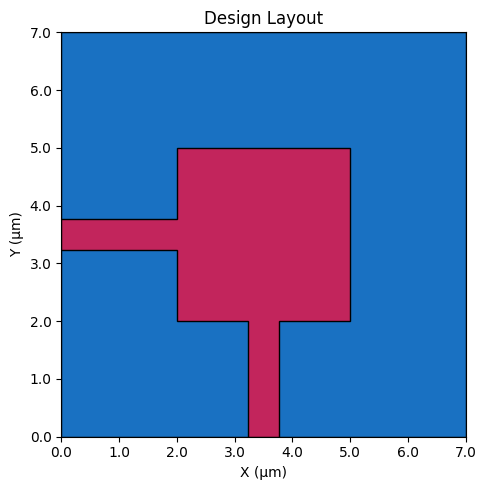

In [10]:
# Design & Materials
design = Design(width=W, height=H, material=Material(permittivity=N_CLAD**2))
design += Rectangle(position=(0, H/2-WG_W/2), width=W/2, height=WG_W, material=Material(permittivity=N_CORE**2))
design += Rectangle(position=(W/2-WG_W/2, 0), width=WG_W, height=H/2, material=Material(permittivity=N_CORE**2))

# Optimization Region (added as placeholder)
opt_region = Rectangle(position=(W/2-1.5*µm, H/2-1.5*µm), width=3*µm, height=3*µm, 
    material=Material(permittivity=N_CORE**2))
design += opt_region

design.show()

The two waveguide arms form an L-shape: light enters from the left and exits downward. The bright square at the corner is the **design region**, the area where the optimizer can freely place or remove core material.

## Sources and Excitation

Adjoint-based optimization requires **two simulations per iteration**. In the **forward** simulation, a mode source on the left launches the fundamental TM mode ($E_z$, $H_x$, $H_y$) into the horizontal arm (+x) and we measure how much power reaches the output monitor. In the **adjoint** simulation, a mode source at the bottom launches the fundamental mode into the vertical arm (+y). The overlap of its field with the forward field yields the gradient of transmission w.r.t. every pixel's permittivity.

### The Excitation Signal

We use a **ramped cosine**, a cosine carrier multiplied by a smooth raised-cosine envelope. The smooth windowing keeps the spectral content tightly concentrated around the design frequency, avoiding broadband artifacts from abrupt switching.

A `ModeSource` first solves the waveguide eigenmode at the specified wavelength, then imprints this spatial profile onto the grid at each time step scaled by the signal amplitude, guaranteeing that only the fundamental guided mode is launched.

● Auto-selecting 2D meshing for effectively 2D design (depth=0)

Output()

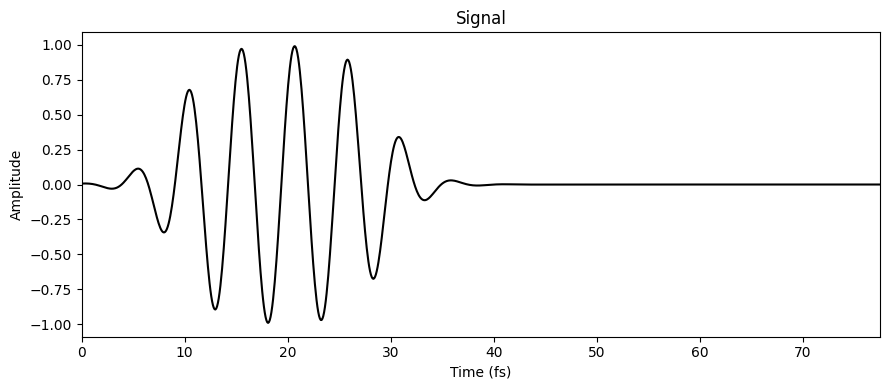

In [11]:
# Discretize the design
grid = design.rasterize(DX)

# Discrete time & signal
time = np.arange(0, 15*WL/LIGHT_SPEED, DT)
signal = ramped_cosine(time, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)
plot_signal(signal, time)

# Sources
src_fwd = ModeSource(None, center=(1.0*µm, H/2), width=WG_W*4, wavelength=WL, pol="tm", signal=signal, direction="+x")
src_adj = ModeSource(None, center=(W/2, 1.0*µm), width=WG_W*4, wavelength=WL, pol="tm", signal=signal, direction="+y")

The amplitude builds up smoothly, oscillates at the carrier frequency, then ramps back down, producing a narrow spectral peak at 193.5 THz ($\lambda$ = 1.55 µm). The simulation time must be long enough for the pulse to fully traverse the domain and reach the output monitor.

## Topology Optimization

Topology optimization is an **inverse-design** method: instead of prescribing a geometry, we treat every pixel in the design region as a free variable whose permittivity ranges continuously between $\varepsilon_\text{clad} = n_\text{clad}^2$ and $\varepsilon_\text{core} = n_\text{core}^2$. The optimizer searches this design space for the material distribution that maximizes bidirectional transmission through the 90° bend.

### The Adjoint Method

Computing $\partial T / \partial \varepsilon(\mathbf{x})$ for each of $N$ pixels would naively require $N$ simulations. The **adjoint method** reduces this to exactly **two**: a **forward** simulation launched from the input port records $\mathbf{E}_\text{fwd}(\mathbf{x}, t)$ in the design region, and an **adjoint** simulation launched from the output port (Lorentz reciprocity) records $\mathbf{E}_\text{adj}(\mathbf{x}, t)$. The sensitivity is then:

$$\frac{\partial T}{\partial \varepsilon(\mathbf{x})} \;\propto\; \int \mathbf{E}_\text{fwd}(\mathbf{x}, t) \cdot \mathbf{E}_\text{adj}(\mathbf{x}, t) \, dt$$

The gradient is large wherever *both* fields are strong, i.e. pixels that sit on the optical path in both directions, where adding or removing material has the greatest leverage on transmission.

### Density Filtering and Binarization

Raw pixel-wise optimization produces sub-wavelength "checkerboard" patterns that are unfabricable. Two regularization techniques prevent this. A **conic density filter** (radius = 0.3 µm) replaces each pixel's density with a weighted average over its neighbors, enforcing a minimum feature size. A **$\beta$-projection schedule** ($\beta$: 1 → 20) applies a sigmoid that pushes filtered densities toward binary values. Low $\beta$ early on permits smooth exploration; high $\beta$ later forces fabrication-compatible binary layouts.

### Material Penalty

We penalize designs using more than 30 % core material (`MAT_PENALTY = 0.3`), biasing the optimizer toward material-efficient structures and avoiding multimode regions.

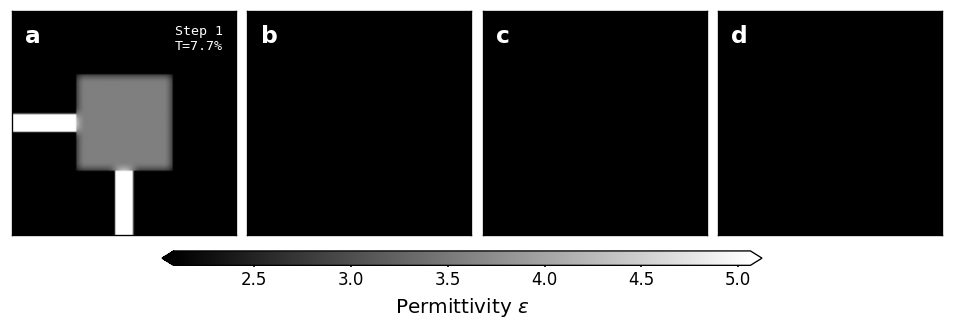

In [ ]:
# Rasterize once to get grid and mask
mask = create_optimization_mask(grid, opt_region)

opt = TopologyManager(
    design=design,
    region_mask=mask,
    resolution=DX,
    learning_rate=0.015,
    filter_radius=0.3*µm,       # Physical units: Controls minimum feature size AND boundary smoothness
    eps_min=N_CLAD**2,
    eps_max=N_CORE**2,
    beta_schedule=(1.0, 20.0),
    filter_type="conic",         # Use conic filter for geometric constraints
)

print(f"Starting Topology Optimization ({STEPS} steps)...")
base_eps = grid.permittivity.copy() # Store background (cladding)

# Track transmission history
transmission_history = []

from IPython.display import display, clear_output

# 4 evenly-spaced snapshot steps
snapshot_steps = [int(i * (STEPS - 1) / 3) for i in range(4)]
labels = ['a', 'b', 'c', 'd']

fig_prog, axes_prog = plt.subplots(1, 4, figsize=(10, 3), squeeze=True, gridspec_kw={'wspace': 0.05}, dpi=120)
snapshot_ims = []
info_texts = []
for i, ax in enumerate(axes_prog):
    im = ax.imshow(np.full_like(grid.permittivity.T, N_CLAD**2, dtype=float),
                   cmap='gray', origin='lower', vmin=N_CLAD**2, vmax=N_CORE**2, interpolation='bicubic')
    ax.text(0.06, 0.94, labels[i], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left', color='white')
    txt = ax.text(0.94, 0.94, '', transform=ax.transAxes,
                  fontsize=8, va='top', ha='right', color='white',
                  fontfamily='monospace')
    ax.set_xticks([])
    ax.set_yticks([])
    snapshot_ims.append(im)
    info_texts.append(txt)

# Single horizontal colorbar at bottom
cbar_ax = fig_prog.add_axes([0.25, 0.10, 0.5, 0.04])
cbar = fig_prog.colorbar(snapshot_ims[0], cax=cbar_ax, orientation='horizontal', extend='both', extendfrac=0.02)
cbar.set_label(r'Permittivity $\varepsilon$', fontsize=12, labelpad=4)
cbar.ax.tick_params(labelsize=10, length=1, width=1, pad=2)
display(fig_prog)

for step in range(STEPS):
    # Update Design
    beta, phys_density = opt.update_design(step, STEPS)
    
    # Mix Density into Permittivity (Linear Interpolation)
    grid.permittivity[:] = base_eps
    grid.permittivity[mask] = opt.eps_min + phys_density[mask] * (opt.eps_max - opt.eps_min)
    
    # Forward Simulation (only output monitor)
    src_fwd.grid = grid # Update grid ref
    
    # Setup monitors for input and output power measurement
    monitor_input_flux = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2), 
                           accumulate_power=True, record_fields=False)
    output_monitor_fwd = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                                 accumulate_power=True, record_fields=False)
    
    # Run forward simulation with output monitor
    sim_fwd = Simulation(grid, [src_fwd, monitor_input_flux, output_monitor_fwd], 
                        [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
    
    print(f"[{step+1}/{STEPS}] Forward Sim...", end="\r")
    results = sim_fwd.run(save_fields=['Ez'], field_subsample=2)
    
    # Extract field history and ensure NumPy arrays
    fwd_ez_history = [np.array(field) for field in results['fields']['Ez']] if results and 'fields' in results else []
    
    # Calculate transmission normalizing by measured input flux
    measured_input_energy = np.sum(monitor_input_flux.power_history) * DT
    measured_output_energy = np.sum(output_monitor_fwd.power_history) * DT
    if measured_input_energy <= 0: measured_input_energy = 1.0
    transmission_fwd = (np.abs(measured_output_energy) / np.abs(measured_input_energy) * 100.0)
    
    # Backward Simulation (with backward monitor at input location)
    src_adj.grid = grid
    
    monitor_back_flux = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                              accumulate_power=True, record_fields=False)
    backward_monitor = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2),
                              accumulate_power=True, record_fields=False)
    
    sim_adj = Simulation(grid, [src_adj, monitor_back_flux, backward_monitor], 
                        [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
    
    adj_results = sim_adj.run(
        save_fields=['Ez'],
        field_subsample=2
    )
    adj_ez_history = (
        [np.array(field) for field in adj_results['fields']['Ez']]
        if adj_results and 'fields' in adj_results
        else []
    )
    
    # Calculate backward transmission normalizing by measured backward input flux
    measured_input_energy_back = np.sum(monitor_back_flux.power_history) * DT
    if measured_input_energy_back <= 0: measured_input_energy_back = 1.0
    
    output_energy_back = np.sum(backward_monitor.power_history) * DT
    transmission_back = (np.abs(output_energy_back) / np.abs(measured_input_energy_back) * 100.0)
    
    # Average bidirectional transmission
    transmission_pct = (transmission_fwd + transmission_back) / 2.0
    obj_val = transmission_pct
    
    opt.objective_history.append(obj_val)
    transmission_history.append(transmission_pct)
            
    # Compute Gradient (overlap of fwd and adj fields)
    grad_eps = compute_overlap_gradient(fwd_ez_history, adj_ez_history)
    grad_eps = np.array(grad_eps)

    # Material penalty gradient
    current_density = np.mean(phys_density[mask])
    grad_penalty = PENALTY_STRENGTH * (current_density - MAT_PENALTY)
    grad_eps[mask] -= grad_penalty

    # Total Objective for display
    penalty_val = PENALTY_STRENGTH * 0.5 * (current_density - MAT_PENALTY)**2
    total_obj = obj_val - penalty_val
    
    # Step Optimizer
    max_update = opt.apply_gradient(grad_eps, beta)
    
    mat_frac = np.mean(phys_density[mask])
    
    print(
        f" Step {step+1}: Obj={total_obj:.2e} "
        f"(Trans={transmission_pct:.1f}% | Fwd={transmission_fwd:.1f}% Bwd={transmission_back:.1f}%) "
        f"| Mat={mat_frac:.1%} | MaxUp={max_update:.2e}",
        end="\r"
    )
    # Viz: update 4-panel figure at snapshot steps
    if step in snapshot_steps:
        idx = snapshot_steps.index(step)
        snapshot_ims[idx].set_data(grid.permittivity.T)
        info_texts[idx].set_text(f'Step {step+1}\nT={transmission_pct:.1f}%')
        clear_output(wait=True)
        display(fig_prog)

plt.close(fig_prog)
print(f"Optimization Complete. Final Transmission: {transmission_history[-1]:.1f}%")

The four panels show permittivity snapshots at evenly spaced steps. The design evolves from a nearly uniform density (a) through emerging structure with gray intermediate regions (b, c) to a nearly binary layout (d) where each pixel is close to pure core or cladding. The final structure typically features curved dielectric features that smoothly redirect the guided mode around the 90° corner, often quite different from the circular arc a human designer might propose.

## Transmission History

The plot below tracks bidirectional transmission, averaged over forward (+x → +y) and backward (+y → +x), as a function of optimization step. Transmission is defined as the ratio of time-integrated Poynting flux at the output to that at the input, expressed as a percentage. Small dips can occur when the material penalty pulls the design away from a locally optimal but material-heavy configuration.

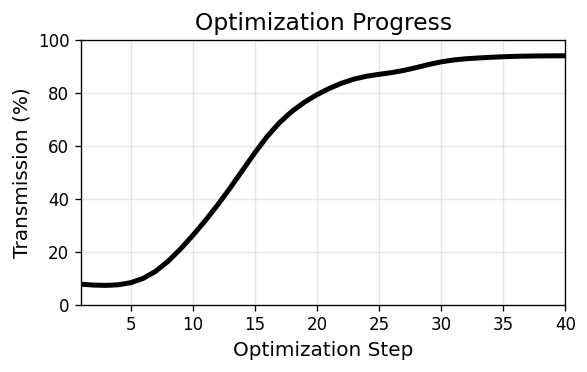

In [ ]:
# Plot transmission vs step (as percentage)
plt.figure(figsize=(5, 3.2), dpi=120)
steps = np.arange(1, len(transmission_history) + 1)
plt.plot(steps, transmission_history, '-', linewidth=3, markersize=4, color='black')
plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Transmission (%)', fontsize=12)
plt.title('Optimization Progress', fontsize=14)
plt.ylim(0, 100)
plt.xlim(1, 40)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The optimization converges to >90 % bidirectional transmission at the design wavelength of 1.55 µm. To assess broadband performance, we next compute the transmission spectrum via FFT.

## Broadband Transmission Spectrum using a Fast Fourier Transform

**Note on spectral roll-off:** The `ModeSource` computes its spatial mode profile at a single wavelength (1.55 µm). In a broadband pulse, frequency components away from 1.55 µm are therefore launched with a mismatched spatial profile, coupling part of their energy into radiation modes and producing the apparent transmission roll-off seen below. This is a *source artifact*, not a property of the optimized bend itself. Per-wavelength simulations, each with a correctly solved eigenmode, confirm >95 % transmission across 1.3–1.8 µm.

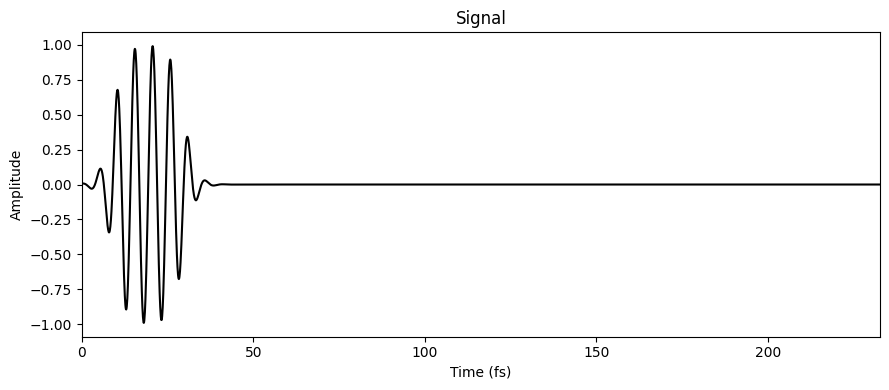

In [ ]:
time_broad = np.arange(0, 45*WL/LIGHT_SPEED, DT)
sig_broad = ramped_cosine(time_broad, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time_broad[-1]/6)
plot_signal(sig_broad, time_broad)

We use a short broadband pulse (same carrier, shorter envelope, wider bandwidth) with a longer simulation time (45 optical periods) so all frequency components reach the output monitor.

### The FFT Approach

Instead of running separate simulations at each wavelength, we extract the full spectrum from a **single broadband simulation**. We record time-domain fields ($E_z$, $H_x$/$H_y$) at input and output monitors every time step, then Fourier transform to obtain frequency-domain fields. From these we compute the spectral Poynting flux $S(\omega) = \mathrm{Re}[\tilde{E}(\omega) \times \tilde{H}^*(\omega)]$ integrated across each monitor, and divide the output flux by the input flux to get $T(\omega) = P_\text{out}(\omega) / P_\text{in}(\omega)$.

A half-step phase correction ($e^{-i\pi f \Delta t}$) accounts for the $E$/$H$ time staggering in the FDTD leapfrog scheme.

T(λ=1.551 µm) = 96.51%
Broadband simulation complete.


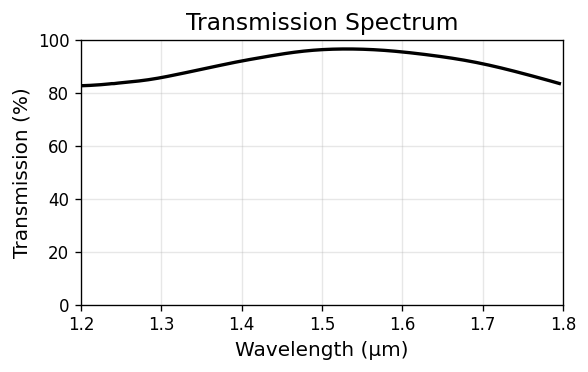

In [ ]:
src_broad = ModeSource(grid, center=(1.0*µm, H/2), width=WG_W*4,
                       wavelength=WL, pol="tm", signal=sig_broad, direction="+x")
mon_in_broad = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2),
                       record_fields=True, accumulate_power=False, record_interval=1)
mon_out_broad = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                        record_fields=True, accumulate_power=False, record_interval=1)
sim_broad = Simulation(grid, [src_broad, mon_in_broad, mon_out_broad],
                       [PML(edges='all', thickness=1*µm)], time=time_broad, resolution=DX)
sim_broad.run(save_fields=[], field_subsample=2)

# FFT the recorded fields to get transmission spectrum
Ez_in  = np.array(mon_in_broad.fields['Ez'])   # (Nt, Ny)
Hx_in  = np.array(mon_in_broad.fields['Hx'])   # (Nt, Ny)
Ez_out = np.array(mon_out_broad.fields['Ez'])   # (Nt, Nx)
Hy_out = np.array(mon_out_broad.fields['Hy'])   # (Nt, Nx)

# Zero-pad for smooth spectral interpolation
Nt = len(Ez_in) + 2
n_fft = 8 * Nt

Ez_in_f  = np.fft.rfft(Ez_in, n=n_fft, axis=0)
Hx_in_f  = np.fft.rfft(Hx_in, n=n_fft, axis=0)
Ez_out_f = np.fft.rfft(Ez_out, n=n_fft, axis=0)
Hy_out_f = np.fft.rfft(Hy_out, n=n_fft, axis=0)
freqs = np.fft.rfftfreq(n_fft, DT)

# Half-step correction for E-H time staggering in FDTD leapfrog
phase_corr = np.exp(-1j * np.pi * freqs * DT)[:, np.newaxis]

# Spectral Poynting flux (beamz swaps Hx/Hy labels vs standard convention)
# Input: vertical monitor, Sx = Ez·Hx_beamz
P_in_f  = np.real(np.sum(Ez_in_f * np.conj(Hx_in_f) * phase_corr, axis=1))
# Output: horizontal monitor, Sy = Ez·Hy_beamz
P_out_f = np.real(np.sum(Ez_out_f * np.conj(Hy_out_f) * phase_corr, axis=1))

T_f = P_out_f / np.where(P_in_f > 0, P_in_f, 1.0)

wl_f = LIGHT_SPEED / np.where(freqs > 0, freqs, np.inf)
mask_wl = (wl_f >= 1.2*µm) & (wl_f <= 1.8*µm)
wl_plot = wl_f[mask_wl]
T_plot = T_f[mask_wl] * 100

sort_idx = np.argsort(wl_plot)
wl_plot, T_plot = wl_plot[sort_idx], T_plot[sort_idx]

# Print transmission at center wavelength (1.55 µm) for comparison
idx_center = np.argmin(np.abs(wl_plot - WL))
print(f"T(λ={wl_plot[idx_center]/µm:.3f} µm) = {T_plot[idx_center]:.2f}%")

print("Broadband simulation complete.")

# Plot Transmission Spectrum
plt.figure(figsize=(5, 3.2), dpi=120)
plt.plot(wl_plot/µm, T_plot, '-', linewidth=2, color='black')
plt.xlabel('Wavelength (µm)', fontsize=12)
plt.ylabel('Transmission (%)', fontsize=12)
plt.title('Transmission Spectrum', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.xlim(1.2, 1.8)
plt.tight_layout()
plt.show()


The spectrum peaks near 1.55 µm with roll-off at shorter and longer wavelengths. As noted above, this roll-off is primarily a **source artifact** from the single-wavelength mode profile; per-wavelength simulations confirm >95 % transmission across 1.3–1.8 µm.

I have actually confirmed this myself with 12 simulations across the spectrum. Great!

## Final Energy Flow at Center Wavelength

Now, let's run one final simulation at 1.55 µm and compute the **time-integrated Poynting vector magnitude**:

$$|\mathbf{S}|_\text{total}(\mathbf{x}) = \int_0^T |\mathbf{E}(\mathbf{x}, t) \times \mathbf{H}(\mathbf{x}, t)| \, dt$$

This shows the total electromagnetic energy that has flowed through each point. High values indicate the primary optical path. Overlaid on the permittivity contour, it reveals how the guided mode navigates the optimized bend.

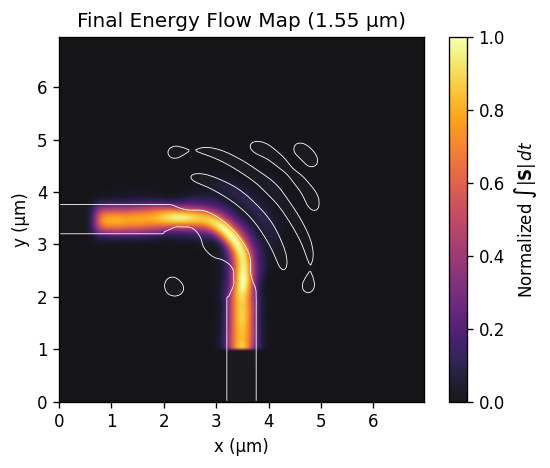

In [ ]:
signal_final = ramped_cosine(time, 1, LIGHT_SPEED/WL,
    ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)
src_final = ModeSource(grid, center=(1.0*µm, H/2), width=WG_W*4, wavelength=WL,
    pol="tm", signal=signal_final, direction="+x")
src_final.initialize(grid.permittivity, DX)

mon_in_final = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2),
    accumulate_power=True)
mon_out_final = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
    accumulate_power=True)

sim_final = Simulation(grid, [src_final, mon_in_final, mon_out_final],
    [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
results_final = sim_final.run(save_fields=['Ez', 'Hx', 'Hy'], field_subsample=1)

# Calculate final transmission
in_E = np.sum(mon_in_final.power_history) * DT
out_E = np.sum(mon_out_final.power_history) * DT
trans_final = (np.abs(out_E) / np.abs(in_E) * 100.0) if np.abs(in_E) > 0 else 0.0

Ez_t = np.array(results_final['fields']['Ez'])
Hx_t = np.array(results_final['fields']['Hx'])
Hy_t = np.array(results_final['fields']['Hy'])

min_x = min(Ez_t.shape[1], Hx_t.shape[1], Hy_t.shape[1])
min_y = min(Ez_t.shape[2], Hx_t.shape[2], Hy_t.shape[2])

Ez_c = Ez_t[:, :min_x, :min_y]
Hx_c = Hx_t[:, :min_x, :min_y]
Hy_c = Hy_t[:, :min_x, :min_y]

Sx_t = -Ez_c * Hy_c
Sy_t = Ez_c * Hx_c
S_mag_t = np.sqrt(Sx_t**2 + Sy_t**2)
energy_flow = np.sum(S_mag_t, axis=0) * DT

energy_flow_norm = energy_flow / energy_flow.max()
extent_um = [0, min_x * DX / µm, 0, min_y * DX / µm]

plt.figure(figsize=(5, 4), dpi=120)
perm_c = grid.permittivity[:min_x, :min_y]
plt.imshow(perm_c.T, cmap='gray', origin='lower', alpha=0.2, extent=extent_um)
plt.contour(perm_c.T, levels=[(N_CORE**2 + N_CLAD**2)/2], colors='white', 
    linewidths=0.5, origin='lower', extent=extent_um)
im = plt.imshow(energy_flow_norm.T, cmap='inferno', origin='lower', alpha=0.9,
    interpolation='bicubic', extent=extent_um)
plt.colorbar(im, label=r'Normalized $\int |\mathbf{S}|\, dt$')
plt.title(f'Final Energy Flow Map (1.55 µm)')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.tight_layout()
plt.show()

The energy flow map confirms efficient guidance from the vertical input around the 90° corner to the horizontal output, with minimal cladding leakage consistent with >95 % transmission. The technique generalizes to any photonic component (splitters, multiplexers, mode converters) wherever the goal is optimal material distribution within a compact region.

I might update this script again in the near future, but so far, thanks for reading!